In [2]:
import numpy as np
import math
import random
import datetime
import statistics
import pandas as pd
import seaborn as sn
import yfinance as yf
import matplotlib.pyplot as plt
from numpy import savetxt
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.tree
from sklearn import metrics  
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from numpy import sqrt
from numpy import argmax
from numpy import arange
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import warnings
from sklearn.metrics import precision_recall_curve

warnings.filterwarnings('ignore')



In [20]:
dates = []
with open('./data/dates.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        dates.append(x)
models = {}
# models['CatBoost'] = CatBoostClassifier(iterations=30, depth=6, learning_rate=0.1,logging_level ='Silent')
# models['Logistic Regression'] = LogisticRegression()
# models['Support Vector Machines'] = LinearSVC()
# models['Decision Trees'] = DecisionTreeClassifier()
# models['Random Forest'] = RandomForestClassifier()
# models['Naive Bayes'] = GaussianNB()
# models['K-Nearest Neighbor'] = KNeighborsClassifier() 
models['RBF SVM'] = SVC(kernel='rbf',gamma=2, C=10,probability = True)
# models['Gaussian Process'] = GaussianProcessClassifier(1.0 * RBF(1.0))  
models['Neural Net'] = MLPClassifier(alpha=1, max_iter=1000)
models['AdaBoost'] = AdaBoostClassifier() 
models['QDA'] = QuadraticDiscriminantAnalysis()

def to_labels(pos_probs, threshold):
     return (pos_probs >= threshold).astype('int')

def get_roc_pre_rec(model,x_validate,y_validate):
    predictions = model.predict_proba(x_validate)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_validate, predictions)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    no_skill = len(y_validate[y_validate==1]) / len(y_validate)
    pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    pyplot.show()
    return thresholds[ix]
    
def get_roc_tpr_fpr(model,x_validate,y_validate):
    predictions = model.predict_proba(x_validate)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_validate, predictions)
    gmeans = sqrt(tpr * (1-fpr))
    ix = argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    return thresholds[ix]
    
def get_thresh_Fscore(model,x_validate,y_validate):
    predictions = model.predict_proba(x_validate)[:, 1]
    thresholds = arange(0, 1, 0.001)
    scores = [f1_score(y_validate, to_labels(predictions, t)) for t in thresholds]
    ix = argmax(scores)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return thresholds[ix]


def top_values(numbers, x):
    sorted_numbers = sorted(numbers, reverse=True)
    top_x = sorted_numbers[:x]
    is_top_value = [False] * len(numbers)
    counter = 0
    for i, number in enumerate(numbers):
        if counter >= x:
            break
        if number in top_x and number >= 0.5 and is_top_value[i] == False:
            is_top_value[i] = True
            counter += 1
            top_x.remove(number)
    return is_top_value
    
def create_sumfile(model,ind,thresh):
    df_model = pd.DataFrame(index = dates[350:370])  
    model_name = model.__class__.__name__
    if "Classifier" in model_name:
        model_name = model_name[:-10]
    print(model_name)
    precision,recall,TpCounter,daily_positive,TotalGainer =[],[],[],[],[]
    target_df = pd.read_csv(f"./data/targets/Targets{ind}.csv")
    for i in range(350,370):
        TPcount,TotalGain = 0,0
        date_df = pd.read_csv(f"./data/dates{ind}/{dates[i]}.csv")
        next_date_df = pd.read_csv(f"./data/dates{ind}/{dates[i+1]}.csv")
        results_df = pd.read_csv(f"./data/dates{ind}/{dates[i+2]}.csv") 
        x_train = date_df.drop(['ticker'], axis=1)                                     #the current day data
        x_validate = next_date_df.drop(['ticker'], axis=1)                             #next day data
        y_train = target_df[dates[i+1]]                                                #takes the next day target
        y_validate = target_df[dates[i+2]]                                             #day after the next target
        scaler = preprocessing.StandardScaler()                                        #define scaler
        x_train, x_validate = scaler.fit_transform(x_train),scaler.fit_transform(x_validate)
        model.fit(x_train, y_train) 
        
        predictions = top_values(model.predict_proba(x_validate)[:,1],thresh)
        
        precision.append(precision_score(y_validate, predictions))
        recall.append(recall_score(y_validate, predictions))
        daily_positive.append(target_df[dates[i+2]].sum())
        
        for i in range(len(predictions)):
            if predictions[i] == True:
#                 print(round(results_df.at[i, 'Close Change']*100,2),results_df.at[i, 'ticker'])
                TotalGain = TotalGain + round(results_df.at[i, 'Close Change']*100,2)
                if y_validate[i] == 1 :
                    TPcount +=1;
        TpCounter.append(TPcount)
        TotalGainer.append(TotalGain)
    df_model[f'P-{model_name}'] = precision
    df_model[f'R-{model_name}'] = recall
    df_model[f'TP-{model_name}'] = TpCounter
    df_model[f'TG-{model_name}'] = TotalGainer
    df_model['DP'] = daily_positive
    df_model.to_csv(f'./data/PrecisionTesting/{ind}/{model_name}-{ind}-{thresh}.csv',index=False)

In [21]:
indices = [2.5,2,1.5]
threshes = [5,20,50,100]
for key in models.keys():
    for ind in indices:
        for thresh in threshes:
            create_sumfile(models[key],ind,thresh)

SVC
SVC
SVC
SVC
SVC
SVC
SVC
SVC
SVC
SVC
SVC
SVC
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
MLP
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
AdaBoost
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis
QuadraticDiscriminantAnalysis


In [ ]:
dataframes = {}
for key in models.keys():
    df_model = pd.DataFrame(index = dates[350:370])  
    model_name = models[key].__class__.__name__
    daily_positive,f_score,accuracy, precision, recall,TpCounter =[],[],[],[],[],[]
    for i in range(350,370):
        TPcount = 0
        date_df = pd.read_csv(f"./data/dates/{dates[i]}.csv")
        next_date_df = pd.read_csv(f"./data/dates/{dates[i+1]}.csv")
        x_train = date_df.drop(['ticker'], axis=1)                                     #the current day data
        x_validate = next_date_df.drop(['ticker'], axis=1)                             #next day data
        y_train = target_df[dates[i+1]]                                                #takes the next day target
        y_validate = target_df[dates[i+2]]                                             #day after the next target
        scaler = preprocessing.StandardScaler()                                        #define scaler
        x_train, x_validate = scaler.fit_transform(x_train),scaler.fit_transform(x_validate)
        models[key].fit(x_train, y_train) 
        predictions = models[key].predict(x_validate)
        accuracy.append(accuracy_score(y_validate, predictions))
        precision.append(precision_score(y_validate, predictions))
        recall.append(recall_score(y_validate, predictions))
        f_score.append(f1_score(y_validate, predictions))
        daily_positive.append(target_df[dates[i+2]].sum())
        for i in range(len(predictions)):
            if y_validate[i] == 1 and predictions[i] == 1:
                TPcount +=1;
        TpCounter.append(TPcount)
    df_model[f'Precision-{model_name}'] = precision
    df_model[f'accuracy-{model_name}'] = accuracy
    df_model[f'recall-{model_name}'] = recall
    df_model[f'f_score-{model_name}'] = f_score
    df_model[f'TPcounter-{model_name}'] = TpCounter
    df_model['daily_positive'] = daily_positive
    dataframes[model_name]= df_model

    
writer = pd.ExcelWriter('./data/ModelsInformation.xlsx', engine='xlsxwriter')
for sheet_name, df in dataframes.items():
    df.to_excel(writer, sheet_name=sheet_name)
#     df_model.to_excel("./data/ModelsInformation.xlsx",sheet_name=f'{model_name}')
writer.save()

In [ ]:
content = ['Precision','accuracy','recall','f_score']
df_dict = pd.read_excel('./data/models_information/ModelsInformation.xlsx', sheet_name=None)
for amuda in content:
    df2 = pd.DataFrame(index = dates[350:370])  
    for name, df in df_dict.items():
        col = df.loc[:,df.columns.str.contains(f'^{amuda}')]
        df2[f"{amuda}-{name}"] = col.values
    df2.to_csv(f'./data/models_information/all{amuda}.csv',index= False)

    

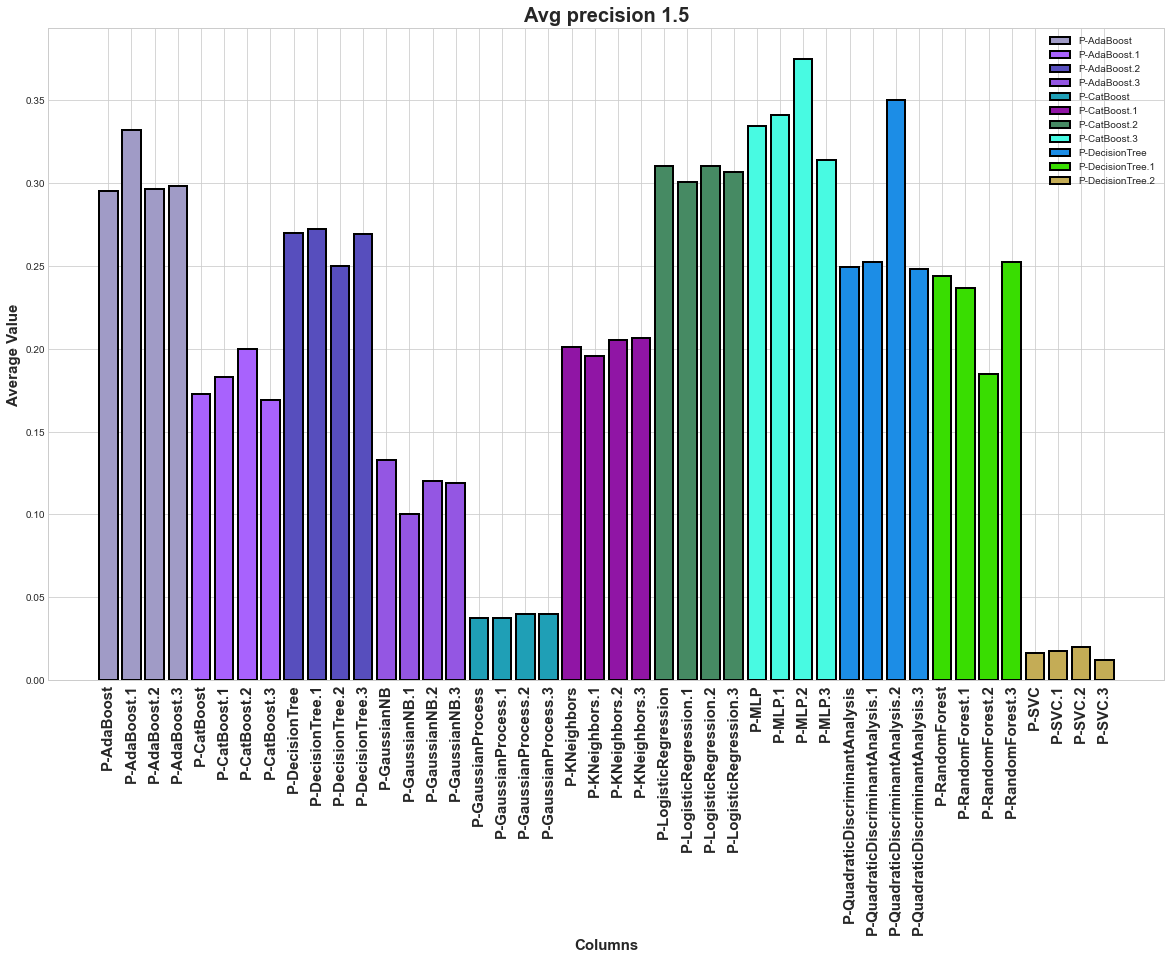

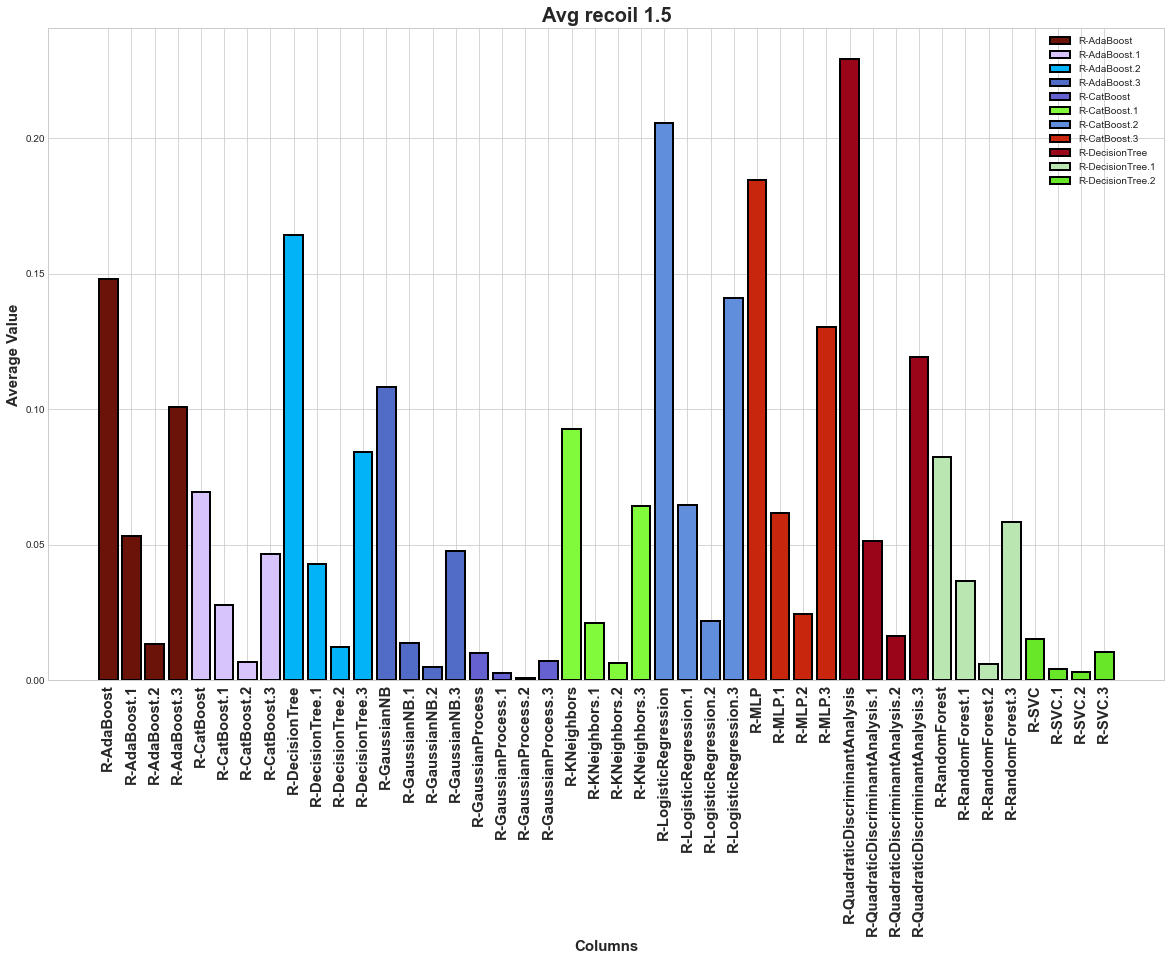

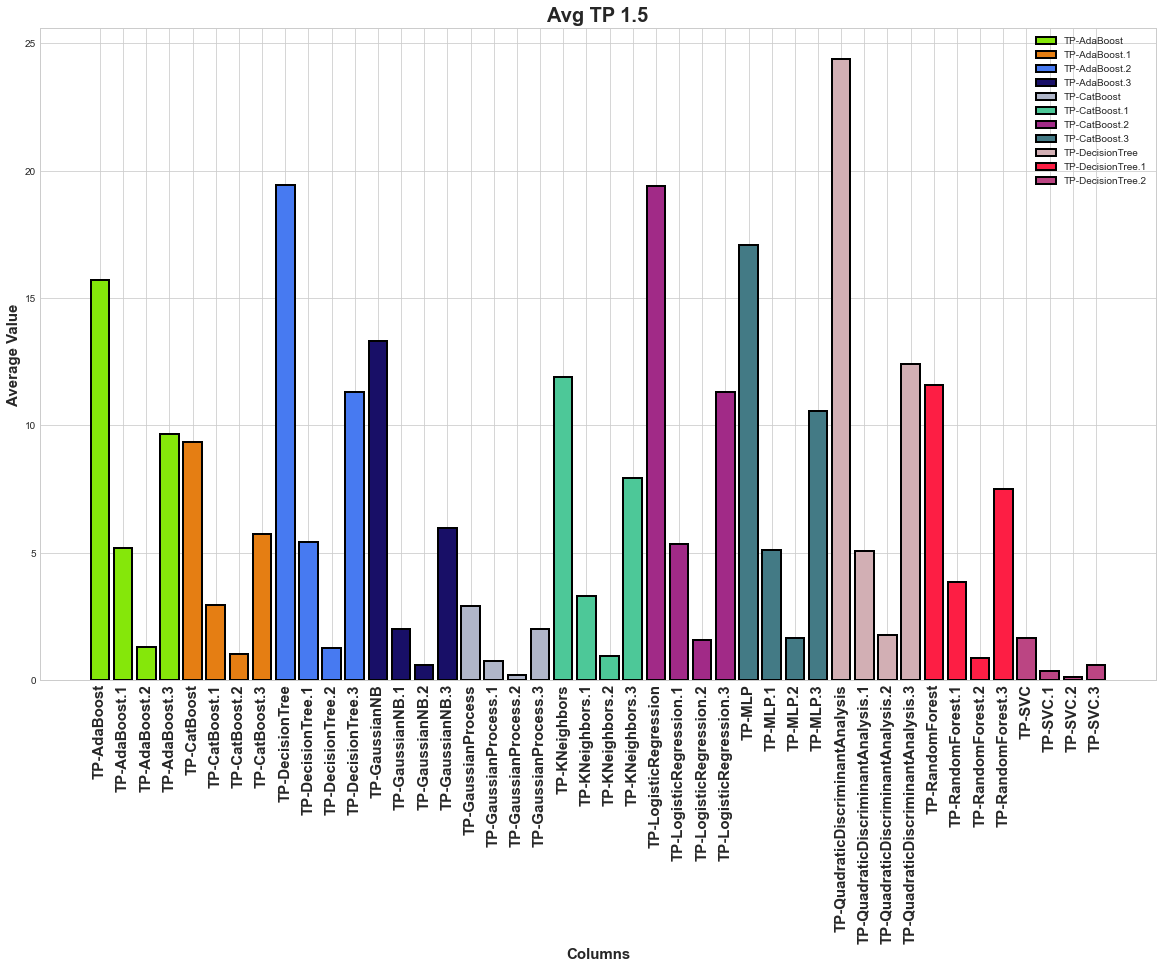

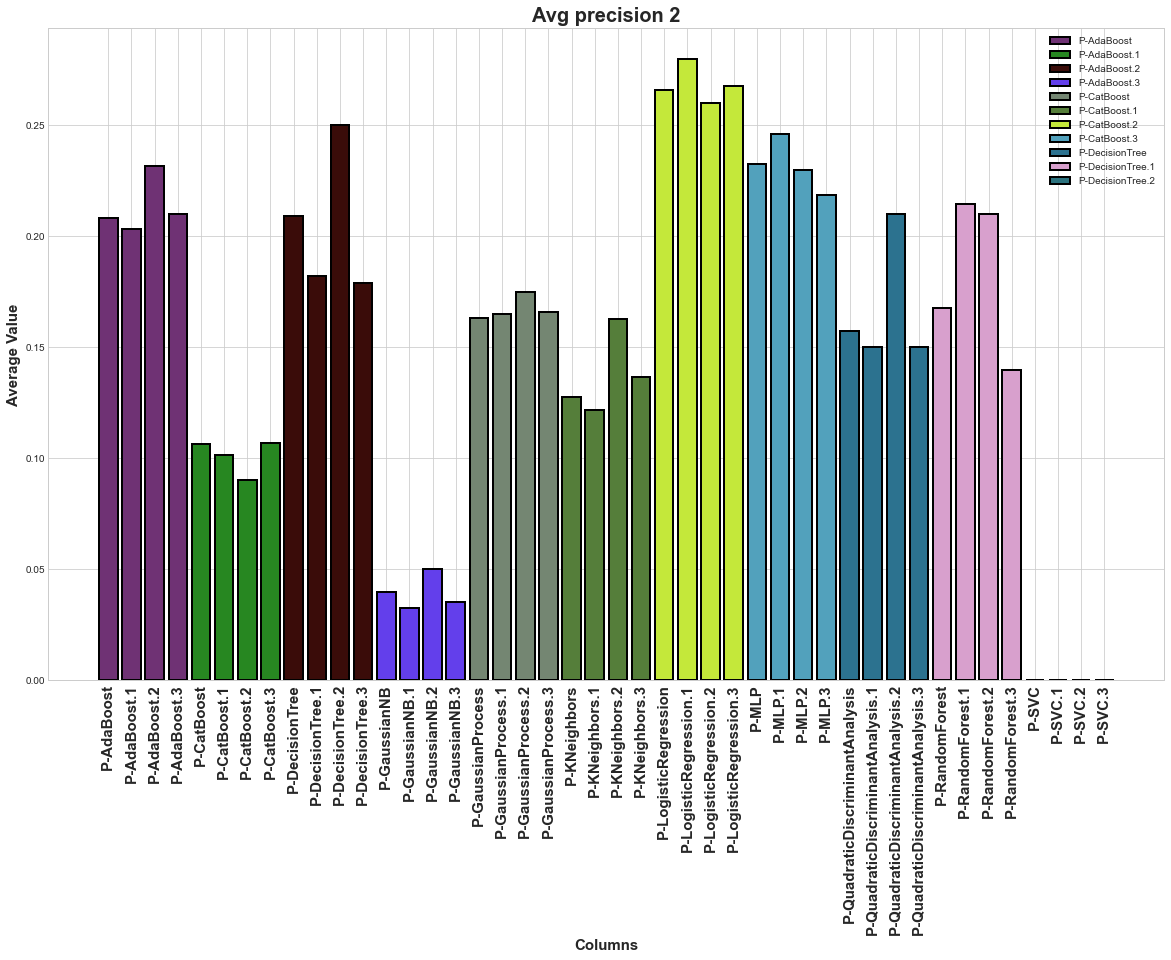

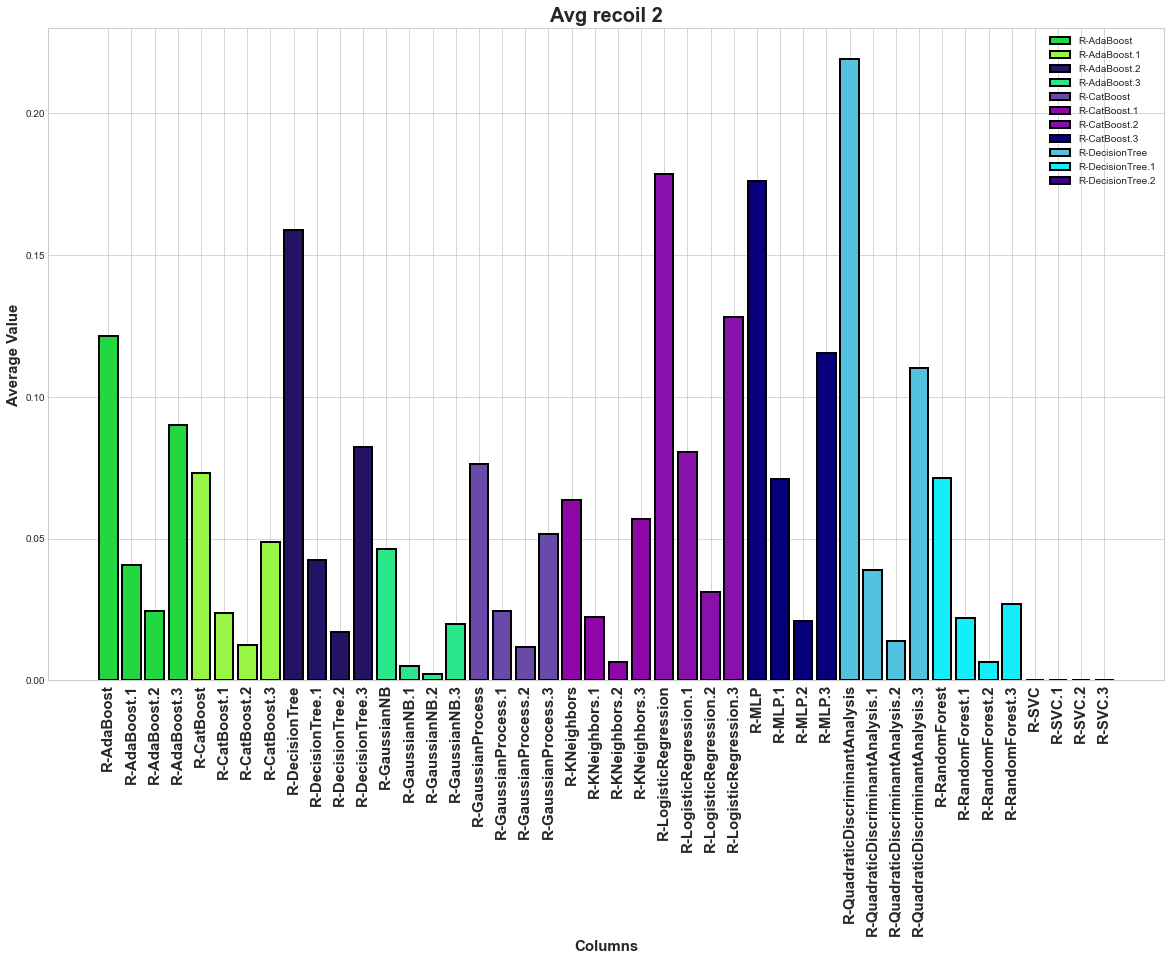

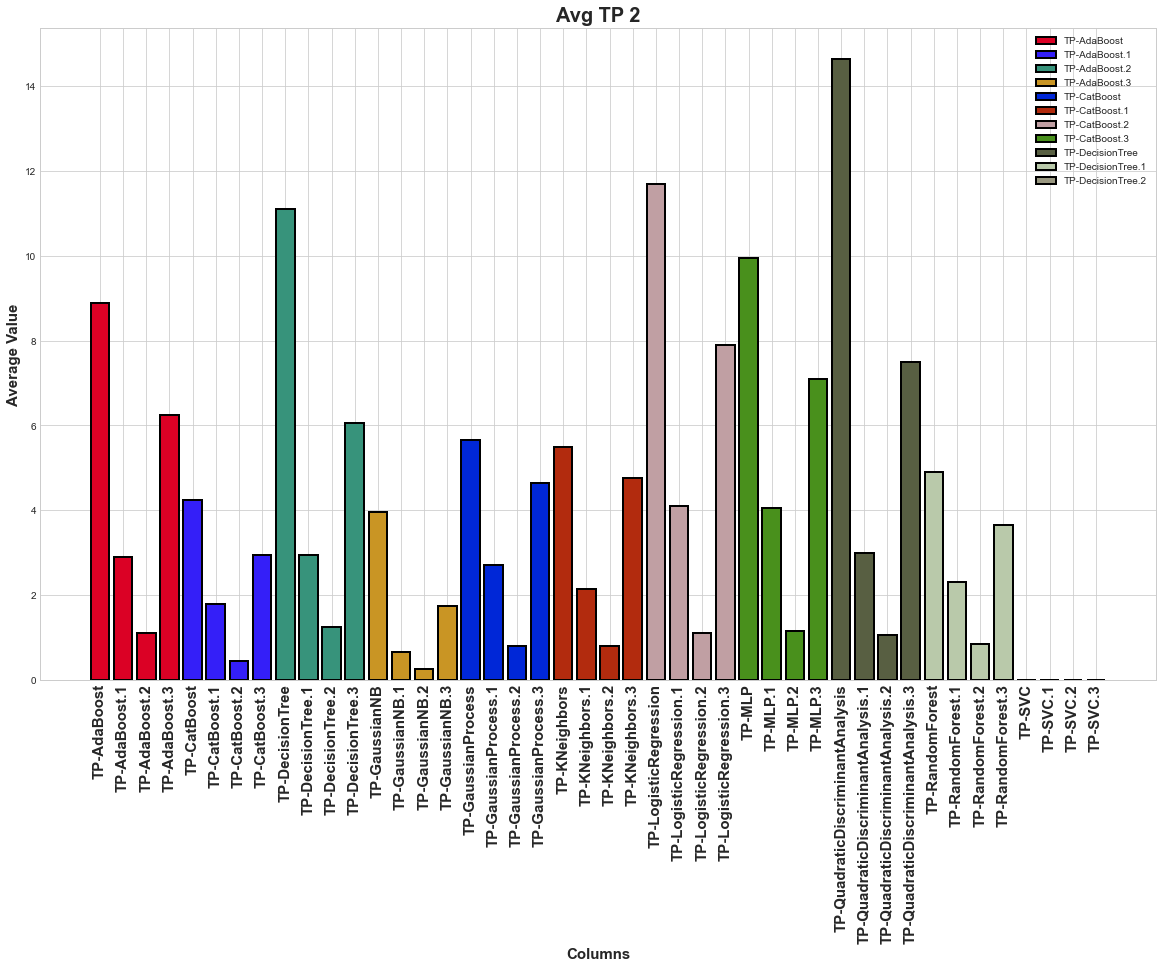

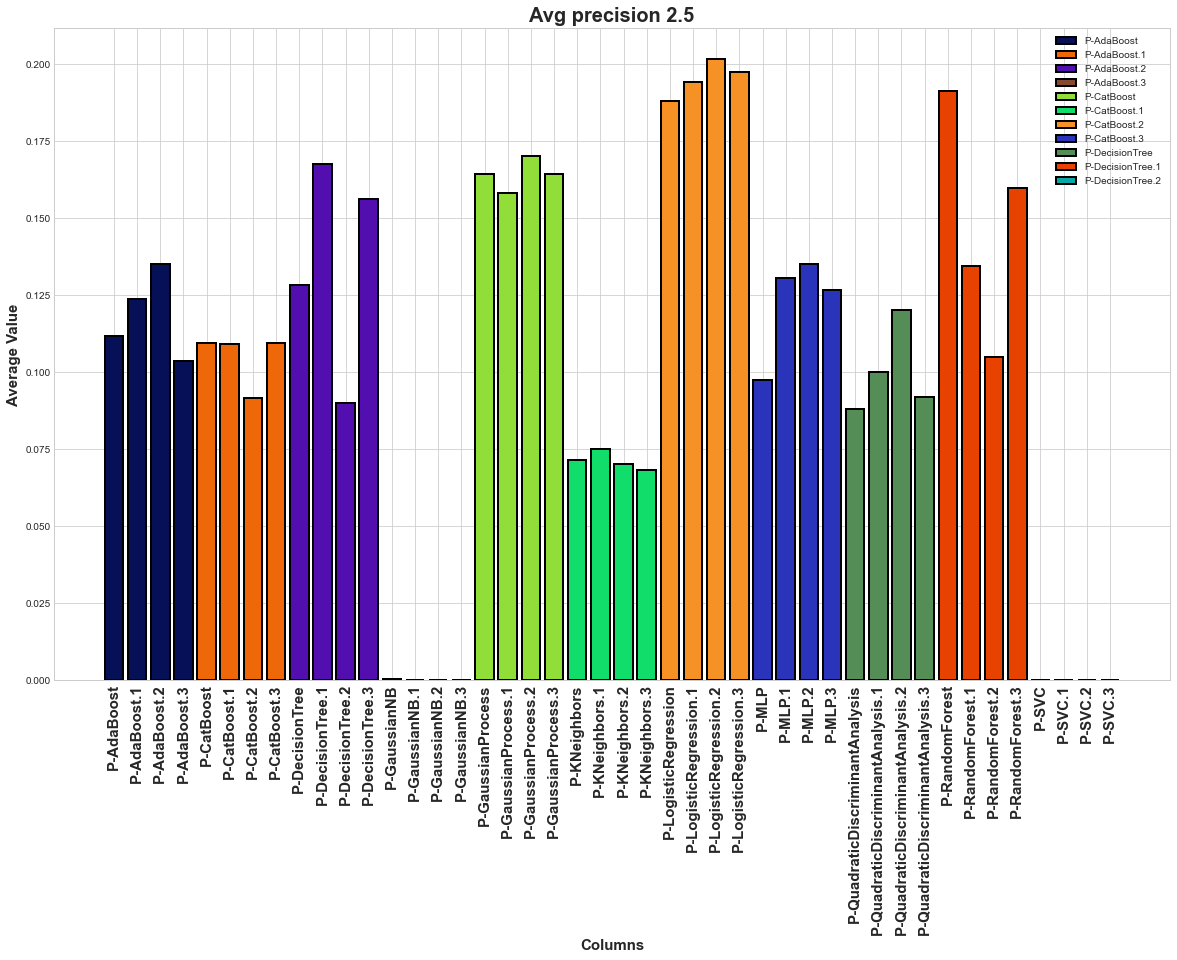

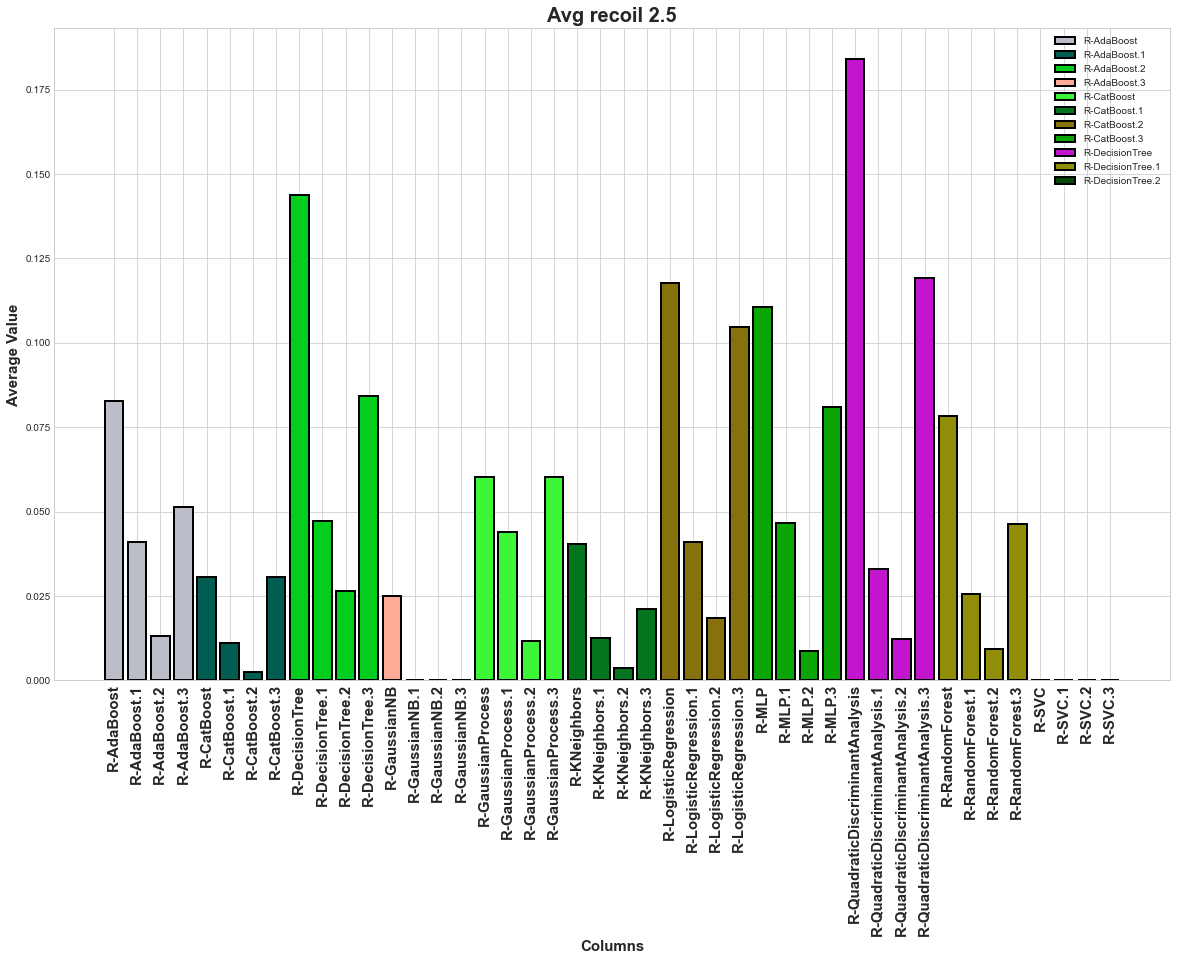

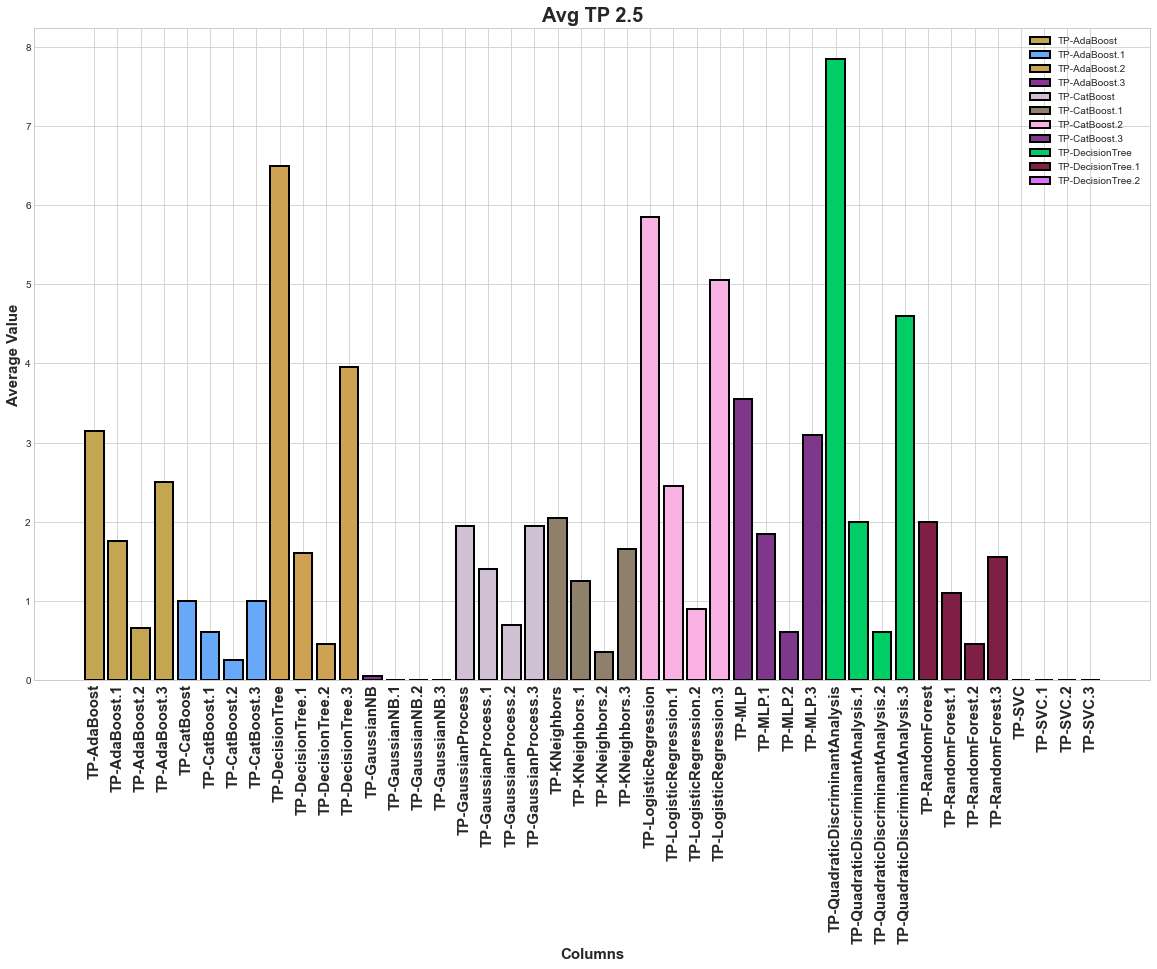

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import random

def get_graph(ind , pre, name):
    df = pd.read_excel(f"./data/PrecisionTesting/finals/full_outcome{ind}.xlsx")
    avg_cols = df.iloc[:,pre::3].mean()
    plt.figure(figsize=(20,12)) # Make it 14x7 inch
    plt.style.use('seaborn-whitegrid') # nice and clean grid
    colors = ['#{:06x}'.format(random.randint(0, 2**24 - 1)) for _ in range(11)]
    for i in range(0, len(avg_cols), 4):
        plt.bar(avg_cols.index[i:i+4], avg_cols.values[i:i+4], color=colors[i//4], edgecolor='#000000', linewidth=2)
    plt.title(f"Avg {name} {ind}", fontsize = 20, weight = 'bold')
    plt.xlabel("Columns", fontsize = 15, weight = 'bold')
    plt.ylabel("Average Value", fontsize = 15, weight = 'bold')
    plt.legend(avg_cols.index[0:44])
    plt.xticks(rotation=90, fontsize = 15, weight = 'bold')
    plt.show()

get_graph(1.5,0,'precision')
get_graph(1.5,1,'recoil')
get_graph(1.5,2,'TP')
get_graph(2,0,'precision')
get_graph(2,1,'recoil')
get_graph(2,2,'TP')
get_graph(2.5,0,'precision')
get_graph(2.5,1,'recoil')
get_graph(2.5,2,'TP')